Using multidimensional priors with astromatch
========================================


This examples uses a source catalogue from the XMM-ATLAS survey (http://xraygroup.astro.noa.gr/atlas.html). The used catalogue is the result of custom X-ray data analysis and does not correspond to the one provided  in the lnk above The catalogue is loaded as an astromatch Catalogue object. The corresponding MOC that describes the XMM-ATLAS field of view is also given. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from astromatch import Catalogue
from mocpy import MOC


xcat_moc_file = Path("DATA", "xmmatlas_new.moc")
xcat_moc = MOC.from_fits(xcat_moc_file)     

xcat_file = Path("DATA", "xmmatlas_srclistnew_Legacy.fits")
xcat = Catalogue(
    str(xcat_file),
    name='xatlas',
    id_col='UXID',
    coord_cols=['RA_CORR', 'DEC_CORR'],
    poserr_cols=['RADEC_TERR'],
    poserr_type='circle',
    area=xcat_moc,
)

print("{} sources in sky area of {:0.01f}".format(len(xcat), xcat.area))

1127 sources in sky area of 7.0 deg2


The next steps is to define the optical catalogue through an astromatch Catalogue object. In this case the [Legacy survey](http://legacysurvey.org/) dataset is used. The table columns of the Legacy survey source list that will be read into the Catalogue class need to be defined.  At this stage no prior is contructed but the relevant columns are read in for the calculations later on.

In [3]:
from astropy import units as u


ocat_mags = ['MAG_G', 'MAG_Z', 'GAIA_PHOT_G_MEAN_MAG', 'MAG_W1', 'MAG_W2']

ocat_moc_file = Path("DATA", "legacy.moc")
ocat_moc = MOC.from_fits(ocat_moc_file)

ocat_file = Path("DATA", "Legacy_SLIM.fits")
ocat = Catalogue(
    str(ocat_file),
    name='lgcy',
    id_col='UOBJID',
    coord_cols=['RA', 'DEC'],
    poserr_cols=['RADEC_ERR'],
    poserr_type='circle',
    area=ocat_moc,
    mag_cols=ocat_mags,
)

# The moc includes the whole area of the legacy survey, 
# but the data in Legacy_SLIM.fits contains only sources
# in the xatlas area. This is corrected later on when we
# define the match, since only the common area between 
# catalogues is taken into account.
print("{} sources in sky area of {:0.01f}".format(len(ocat), ocat.area))

552530 sources in sky area of 190.0 deg2


Define the Match object of the two catalogues. 



In [4]:
from astromatch import Match

xm = Match(xcat, ocat)

INFO: Selecting sources in common area... [astromatch.core]
INFO: xatlas catalogue: 1127 sources in common area. [astromatch.core]
INFO: lgcy catalogue: 552530 sources in common area. [astromatch.core]


The two catalogue are matched. Here we define the columns that will be used for the construction of priors. The construction of priors also require boundaries and bin sizes to construct the corresponding N-dimensional histograms. There are also defined here. Priors are calculated internally (and can be access later on using the 'prior' property of 'xm').

With the following definitions they consist of one 2-D prior from the MAG_G and MAG_Z columns in the 'ocat' Catalogue object and three 1-D priors using the columns 'MAG_W1', 'MAG_W2', 'GAIA_PHOT_G_MEAN_MAG' in the object. The prior is determined using the "random" method using a total of 100 random samples. The Likelihood Ratio (lr) method is used to determine the probability of sources being associated. The positional offset probability distribution is described by the Rayleigh distribution with sigma the combined positional uncertainty of the sources in each catalogue.  

In [32]:
prior_mags = [['MAG_G', 'MAG_Z'], 'MAG_W1', 'MAG_W2', 'GAIA_PHOT_G_MEAN_MAG']
magmin = [[10, 10], 10, 10, 5]
magmax = [[30, 30], 25, 25, 25]
#bw = ["auto", 0.5, 0.5, 0.5]

match_results = xm.run(
    method='lr',
    radius=7.5*u.arcsec,
    prior_method='random',
    random_numrepeat=100,
    mags=prior_mags,
    magmin=magmin,
    magmax=magmax,
    bw=0.5,
)

INFO: Using LR method: [astromatch.core]
INFO: Searching for match candidates within 7.5 arcsec... [astromatch.lr]
INFO: Calculating priors... [astromatch.lr]
INFO: Estimating priors using Catalogues: xatlas and lgcy... [astromatch.priors]
INFO: Using columns: [['MAG_G', 'MAG_Z'], 'MAG_W1', 'MAG_W2', 'GAIA_PHOT_G_MEAN_MAG'] [astromatch.priors]
INFO: Using columns: [['MAG_G', 'MAG_Z'], 'MAG_W1', 'MAG_W2', 'GAIA_PHOT_G_MEAN_MAG'] [astromatch.priors]
INFO: Calculating likelihood ratios for match candidates... [astromatch.lr]


/home/alnoah/miniconda2/envs/astromatch/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/alnoah/miniconda2/envs/astromatch/lib/python3.8/site-packages/astromatch/lr.py:513: RuntimeWarning: invalid value encountered in true_divide
  lr_table["p_i_" + col] = lr_table["REL_" + col] / lr_table["p_any_" + col]


INFO: Sorting and flagging match results... [astromatch.lr]


it is possible to visualise the prior using the `plot` method:


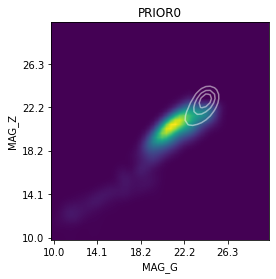

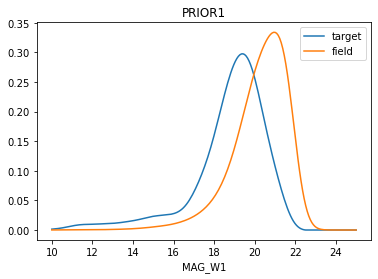

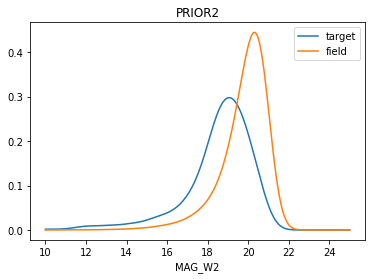

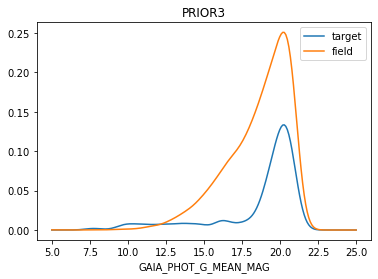

In [33]:
for p in xm.priors.magnames:
    xm.priors.plot(p, contour_levels=3)

The prior can be saved into a fits file:

In [34]:
prior_file = Path("DATA", "prior.fits")
prior_hdu = xm.priors.to_fits(include_bkg_priors=True, filename=prior_file)

prior_hdu.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  PRIOR0        1 BinTableHDU     18   2500R x 3C   ['2D', 'D', 'D']   
  2  PRIOR1        1 BinTableHDU     18   200R x 3C   ['D', 'D', 'D']   
  3  PRIOR2        1 BinTableHDU     18   200R x 3C   ['D', 'D', 'D']   
  4  PRIOR3        1 BinTableHDU     18   200R x 3C   ['D', 'D', 'D']   


INFO: Using provided prior... [astromatch.priors]


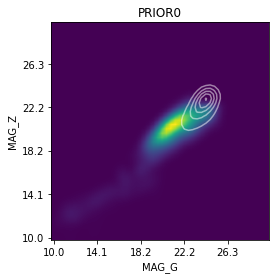

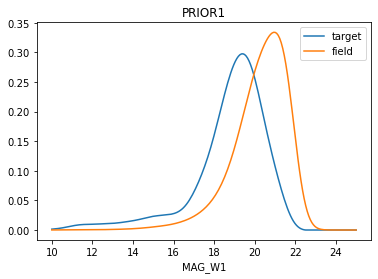

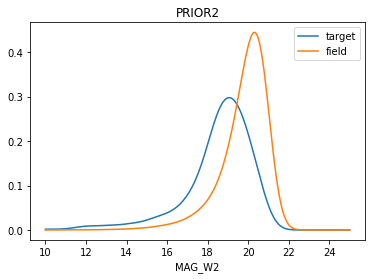

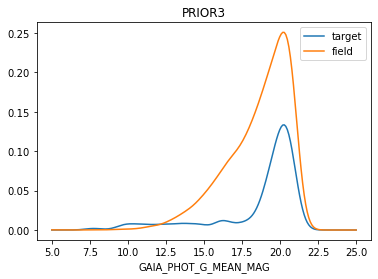

In [36]:
from astromatch.priors import Prior

prior_fits = Prior.from_fits(prior_file)

for p in prior_fits.magnames:
    prior_fits.plot(p, contour_levels=5)

Visualize the results:

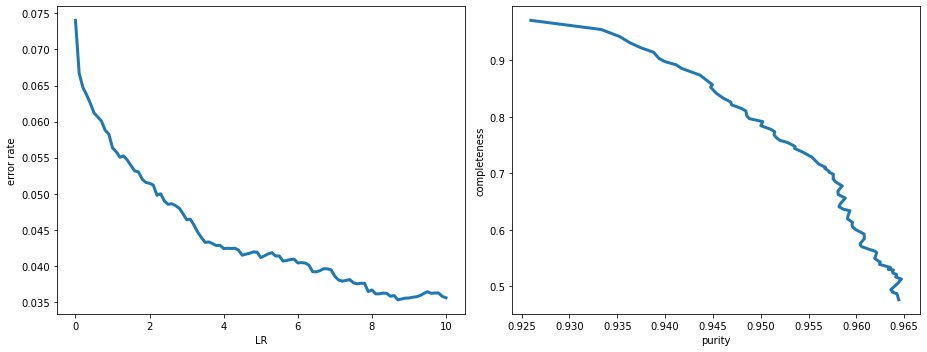

In [40]:
from matplotlib import pyplot as plt


lr_stats = xm.stats(ncutoff=101, maxcutoff=10.0)

fig = plt.figure(figsize=(13, 5))

plt.subplot(121)
plt.plot(lr_stats['cutoff'], lr_stats['error_rate'], lw=3, label="stats")

plt.xlabel('LR')
plt.ylabel('error rate')


plt.subplot(122)
plt.plot(lr_stats['reliability'], lr_stats['completeness'], lw=3)

plt.xlabel('purity')
plt.ylabel('completeness')

plt.tight_layout()
plt.show()

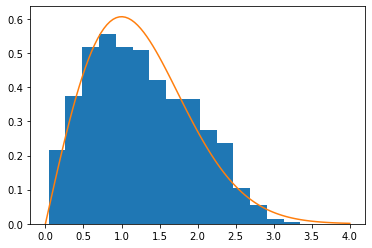

In [44]:
import numpy as np
from astropy import units as u

xm.set_best_matchs(cutoff=0.2)
best_matches = xm.get_matchs(match_type='best')

ocat_best = ocat.select_by_id(best_matches['SRCID_lgcy'])
xcat_best = xcat.select_by_id(best_matches['SRCID_xatlas'])

d = ocat_best.coords.separation(xcat_best.coords)
sigma_x = np.sqrt(ocat_best.poserr.as_array()**2 + xcat_best.poserr.as_array()**2)
dnorm = np.array(d.to(u.arcsec)/sigma_x)

d0 = np.linspace(0, 4, num=100)
f0 = d0 * np.exp(-d0**2/2)

plt.hist(dnorm, bins=15, density=True)
plt.plot(d0, f0)
plt.show()

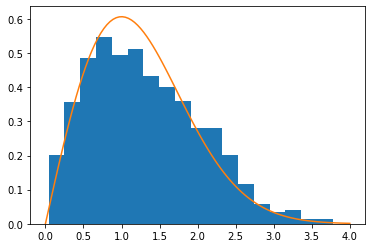

In [46]:
all_matches = xm.get_matchs(match_type='primary')

ocat_all = ocat.select_by_id(all_matches['SRCID_lgcy'])
xcat_all = xcat.select_by_id(all_matches['SRCID_xatlas'])

d = ocat_all.coords.separation(xcat_all.coords)
sigma_x = np.sqrt(ocat_all.poserr.as_array()**2 + xcat_all.poserr.as_array()**2)
dnorm = np.array(d.to(u.arcsec)/sigma_x)

d0 = np.linspace(0, 4, num=100)
f0 = d0 * np.exp(-d0**2/2)

plt.hist(dnorm, bins="auto", density=True)
plt.plot(d0, f0)
plt.show()